In [1]:
import numpy as np

from dataSetPreProcessing import train_validation_test_split
from sklearn.model_selection import train_test_split
from loadDataSet import loadMainDataSet,loadTesteDataSet,loadCompletDataSet,loadMainDataSetWithElevation
from tools import verifyArgs,findBalancedDataSet,pltResults,pltCorrelation, pltLossGraph,pltShow,plotXY,getMetrics,plotLeanrningCurve,getBalancedDataSetIndexRandomState

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# Carregar conjunto de dados
dataSet,features_names,target_names = loadMainDataSetWithElevation()

    Latitude  Longitude  Elevation     Ca      Mg     Na     Cl
0 -14.875833 -39.901389   282.6006  120.0  141.00  172.0  660.0
1 -14.853333 -39.661111   184.0000    0.8    1.45    4.3    7.0


In [3]:

def getParamGrid():
    '''Função que retorna os parâmetro utilizados para encontrar 
    o conjunto de treino balanceado e também na tunagem.
    '''
    param_grid_half = {
        
        'n_estimators':[100], 
        'learning_rate': [0.05], 
        'max_depth':[None], 
        'min_samples_leaf':[3,8], 
        'max_features':['auto','log2'],
        'loss':['ls']
    }
    param_grid_full = {

        'n_estimators':[200], 
        'learning_rate': [0.05,0.01], 
        'max_depth':[None,50,100], 
        'min_samples_leaf':[3,5,8], 
        'max_features':['auto','log2'],
        'loss':['ls','lad','huber','quantile']
    }
    return param_grid_half,param_grid_full

In [4]:
def tuningParameters(model,param_grid,X_train,y_train,verbose=0):
    '''Função que realiza o tuning de parâmetros e também a validação cruzada.'''
    reg =GridSearchCV(model, cv=10,param_grid=param_grid,verbose=verbose,n_jobs=-1,scoring='r2',iid=True)
    reg.fit(X_train,y_train)
    
    print("#Best score:",reg.best_score_)
    print("#Best params:",reg.best_params_)
          
    return reg.best_estimator_,reg.best_params_,reg.best_score_

In [5]:

def getBestSeed(X,y,faixa,verbose=0):
    '''Função responsável por retornar a semênte randômica para a replicação do conjunto de dados balanceado'''
    param_grid_half,_ = getParamGrid()
    maior_score = 0
    seed = 0
    for i in faixa:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=i)
        model = GradientBoostingRegressor(random_state=0)
        best_model,best_params,best_score = tuningParameters(model,param_grid_half,X_train,y_train)
        if best_score>maior_score:
            maior_score = best_score
            seed = i

        y_train_pred = best_model.predict(X_train)
     
    if verbose:
        print("#Maior Score: ",maior_score)
        print("#Seed : ",seed)
   
    return seed,maior_score

In [6]:
def runTest(target,verbose=0):
    '''Executar a busca do melhor modelo para os conjuntos de entrada e o target'''
    X = dataSet[:,:4]
    y = dataSet[:,target]
    seed,score = getBestSeed(X,y,range(1,10),verbose=verbose)

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=seed)
        
    _,param_grid_full = getParamGrid()
    tuningParameters(GradientBoostingRegressor(random_state=0),param_grid_full,X_train,y_train,verbose=verbose)

    print("#Best Seed:",seed)


In [13]:

def avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,param_key_loss,target,verbose=0,stepLoss=25):
    '''Função responsável por apresentar os resultados para cada modelo obtido.'''
    model.fit(X_train,y_train)

    plotLeanrningCurve(X_train,X_val,y_train,y_val,model,param_key_loss,'mean_squared_error',legend_1="Treino",legend_2="Validação",verbose=verbose,step=25)
    plotLeanrningCurve(X_train,X_val,y_train,y_val,model,param_key_loss,'r2',legend_1="Treino",legend_2="Validação",verbose=verbose,step=25)
    
    y_train_pred = model.predict(X_train)
    print("#Metricas para os dados de treino")
    getMetrics(y_train,y_train_pred,verbose=1)
    plotXY(y_train,y_train_pred,"Treino","Predito",target_names[target],"Treino X Predito",midle_line=True)
    
    y_val_pred = model.predict(X_val)    
    print("#Metricas para os dados de validação")
    getMetrics(y_val,y_val_pred,verbose=1)
    plotXY(y_val,y_val_pred,"Validação","Predito",target_names[target],"Validação X Predito",midle_line=True)
     
    y_test_pred = model.predict(X_test)
    print("#Metricas para os dados de teste")
    getMetrics(y_test,y_test_pred,verbose=1)    
    plotXY(y_test,y_test_pred,"Teste","Predito",target_names[target],"Teste X Predito",midle_line=True)
    
    pltCorrelation(model,features_names)

    pltShow()
    

In [14]:



def MELHOR_MG(verbose=0):
    params = {'random_state':0,'learning_rate': 0.05, 'loss': 'lad', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 500}
    model = GradientBoostingRegressor(**params)

    X = dataSet[:,:4]
    y = dataSet[:,4]
   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=9)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=7) 
    avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,'n_estimators',0,verbose=verbose,stepLoss=25,)
   
    #Best score: 0.784343255845013
    #Best params: {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 200}
    #Best Seed: 9
    #Metricas para os dados de treino
    #R-squared: 0.91386
    #Mean Squared Error: 0.00225
    #Metricas para os dados de validação
    #R-squared: 0.85533
    #Mean Squared Error: 0.00267
    #Metricas para os dados de teste
    #R-squared: 0.78551
    #Mean Squared Error: 0.00341





In [15]:
def MELHOR_NA(verbose=0):
    params = {'random_state':0,'learning_rate': 0.05, 'loss': 'lad', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'n_estimators': 750}
    model = GradientBoostingRegressor(**params)

    X = dataSet[:,:4]
    y = dataSet[:,5]
   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=2)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=4) 
    avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,'n_estimators',1,verbose=verbose,stepLoss=50,)
   

    #Best score: 0.6381105225190661
    #Best params: {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 200}
    #Best Seed: 2
    #Metricas para os dados de treino
    #R-squared: 0.89291
    #Mean Squared Error: 0.00237
    #Metricas para os dados de validação
    #R-squared: 0.59301
    #Mean Squared Error: 0.00831
    #Metricas para os dados de teste
    #R-squared: 0.69360
    #Mean Squared Error: 0.00982


In [16]:


def MELHOR_K(verbose=0):
    params = {'random_state':0,'learning_rate': 0.05, 'loss': 'lad', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 500}
    model = GradientBoostingRegressor(**params)

    X = dataSet[:,:4]
    y = dataSet[:,6]
   
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=3)
    X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=0) 
    avaliateModel(model,X_train,X_val,X_test,y_train,y_val,y_test,'n_estimators',2,verbose=verbose,stepLoss=25,)
    #Best score: 0.7244096306794041
    #Best params: {'learning_rate': 0.05, 'loss': 'lad', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 3, 'n_estimators': 200}
    #Best Seed: 3
   #Metricas para os dados de treino                                                                                      
   # #R-squared: 0.98548                                                                                                    
   # #Mean Squared Error: 0.00030                                                                                           
   # #Metricas para os dados de validação                                                                                    
   # #R-squared: 0.74249                                                                                                     
   # #Mean Squared Error: 0.00935                                                                                            
   # #Metricas para os dados de teste                                                                                        
   # #R-squared: 0.71648                                                                                                     
   # #Mean Squared Error: 0.00686   

#Metricas para os dados de treino
#R-squared: 0.90767
#Mean Squared Error: 0.00241
#Metricas para os dados de validação
#R-squared: 0.86993
#Mean Squared Error: 0.00240
#Metricas para os dados de teste
#R-squared: 0.78311
#Mean Squared Error: 0.00345


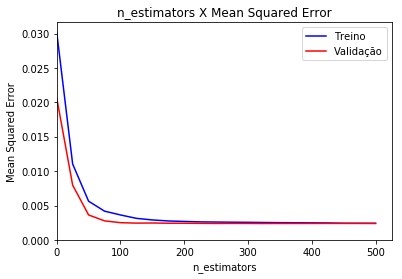

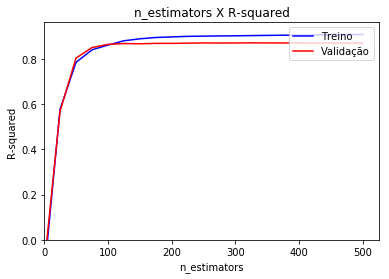

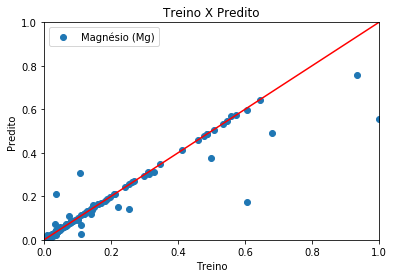

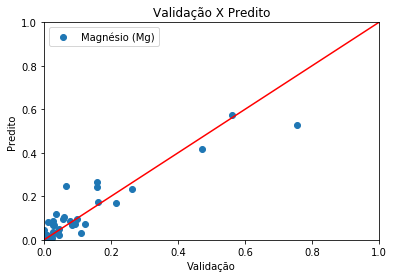

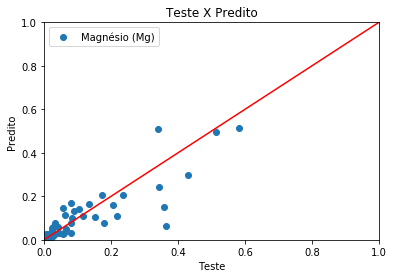

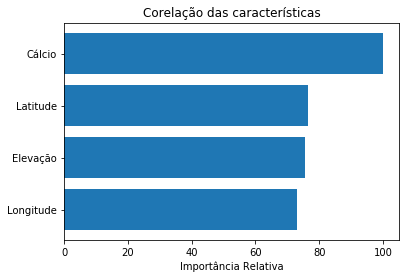

In [17]:
MELHOR_MG()

#Metricas para os dados de treino
#R-squared: 0.90782
#Mean Squared Error: 0.00204
#Metricas para os dados de validação
#R-squared: 0.59637
#Mean Squared Error: 0.00824
#Metricas para os dados de teste
#R-squared: 0.69506
#Mean Squared Error: 0.00978


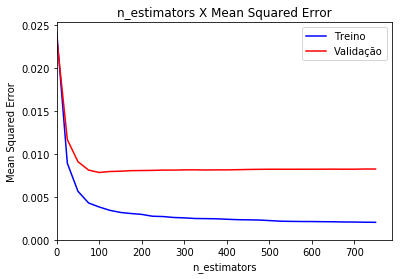

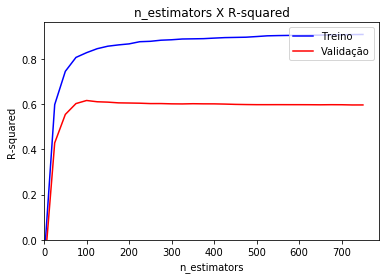

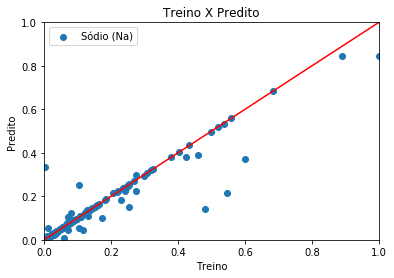

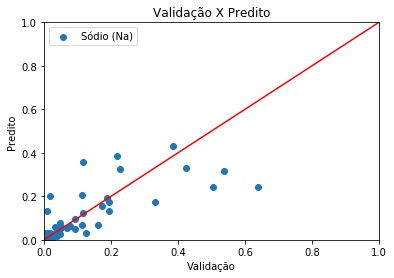

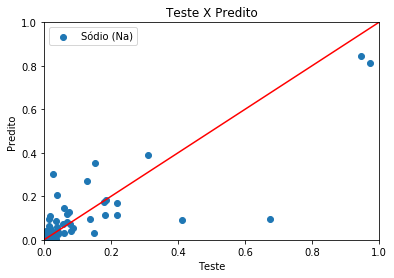

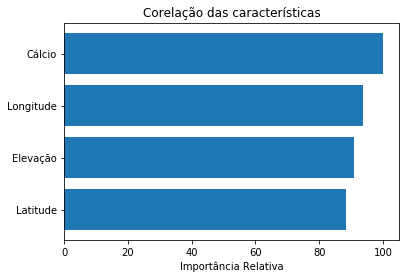

In [18]:
MELHOR_NA()

#Metricas para os dados de treino
#R-squared: 0.98783
#Mean Squared Error: 0.00025
#Metricas para os dados de validação
#R-squared: 0.76451
#Mean Squared Error: 0.00855
#Metricas para os dados de teste
#R-squared: 0.69918
#Mean Squared Error: 0.00728


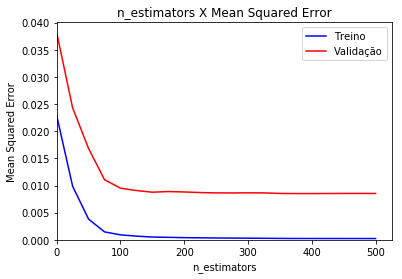

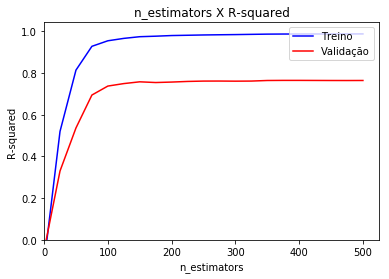

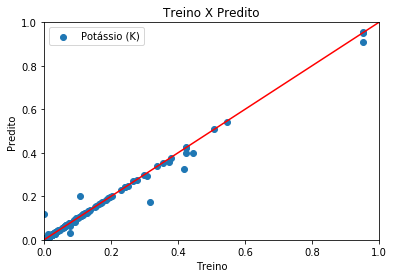

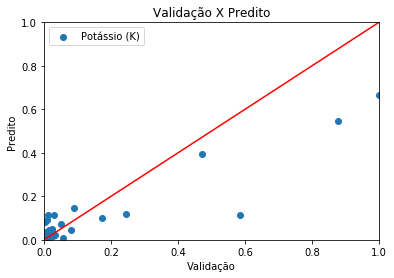

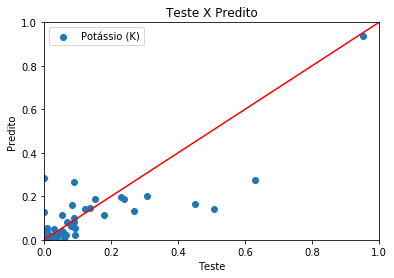

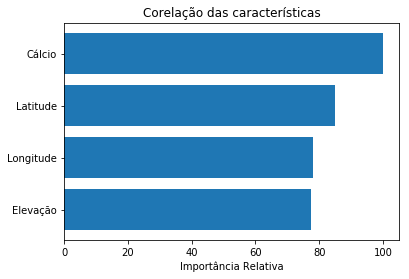

In [19]:
MELHOR_K()